# Thermal Infrared Remote Sensing of Snow: Comparative Analysis of Observation Methods


### Introduction:

This laboratory exercise is designed to help you understand the differences between various sources of thermal infrared (TIR) observations of snow. You will explore the advantages and disadvantages of each method and consider the types of research questions that can be addressed with these observations. 

### Lab Description: :dart: 

In this lab, you will work with three different sources of TIR data collected during the SnowEx 2020 campaign:  
1. Ground-based radiometer measurements from snow pits 
2. Airborne thermal infrared imagery
3. ASTER satellite TIR data 

You will analyze and compare these datasets to understand their spatial and temporal resolutions, accuracy, and potential applications in snow science.

> **Before you start:** :exclamation:
> Download the dataset: 
> - To make thing easier for us, you will download the thermal dataset directly from https://zenodo.org/record/5504396/files/thermal-ir.zip. 
> - Unzip the "thermal-ir.zip" into your lab folder (where this script is located). 


## Fundamental Principles of Thermal Infrared Snow Observation: :memo:

> #### <a id="physics"></a> Physical Basis of TIR Radiation from Snow: 
> Snowpack emits thermal radiation according to the Stefan-Boltzmann law: 
>
> $L=ɛ\sigma T^4$ 
> 
> where $L$ is radiated spectral flux (W/m²/μm), $ɛ$ represents snow emissivity (typically 0.97-0.99 for snow), $\sigma$ is the Stefan-Boltzmann constant (5.67×10⁻⁸ W/m²/K⁴), and $T$ is snow surface temperature in Kelvin. This relationship enables temperature retrieval through careful calibration of TIR sensors across different platforms.



### Some Preamble Before We Start: :speech_balloon: 
##### Import packages: 

In [1]:
# General-purpose packages:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rioxarray
from IPython.display import display, HTML
from shapely.geometry import Polygon

# Packages for working with the SnowEx SQL database:
from snowexsql.db import get_db
from snowexsql.data import SiteData
from snowexsql.conversions import query_to_geopandas

##### Define some useful helper functions: 

In [2]:
# Improved function to reproject geospatial data
def reproject_geospatial(data_array, target_crs="EPSG:26912"):
    """
    Reprojects geospatial data to common coordinate system

    Parameters:
    data_array (xarray.DataArray): Input raster data
    target_crs (str): EPSG code for output projection

    Returns:
    xarray.DataArray: Reprojected dataset
    """
    return data_array.rio.reproject(target_crs)


# Improved code to query and process site data
def get_site_data(site_id, data_id):
    """
    Retrieves site data from the SnowEx database

    Parameters:
    site_id (str): Site identifier
    data_id (str): Data identifier

    Returns:
    GeoDataFrame: Site data
    """
    db_name = "snow:hackweek@db.snowexdata.org/snowex"
    engine, session = get_db(db_name)

    qry = session.query(SiteData).filter(
        SiteData.site_id == site_id, SiteData.id == data_id
    )

    return query_to_geopandas(qry, engine)


# Create a new column 'datetime' by combining 'year', 'doy', and 'time_str'
def compose_date(
    years,
    months=1,
    days=1,
    weeks=None,
    hours=None,
    minutes=None,
    seconds=None,
    milliseconds=None,
    microseconds=None,
    nanoseconds=None,
):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = (
        "<M8[Y]",
        "<m8[M]",
        "<m8[D]",
        "<m8[W]",
        "<m8[h]",
        "<m8[m]",
        "<m8[s]",
        "<m8[ms]",
        "<m8[us]",
        "<m8[ns]",
    )
    vals = (
        years,
        months,
        days,
        weeks,
        hours,
        minutes,
        seconds,
        milliseconds,
        microseconds,
        nanoseconds,
    )
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals) if v is not None)


def tir_dn2rad(DN, band):
    """Convert AST_L1T Digital Number values to At-Sensor Radiance for the TIR bands (bands 10-14)."""
    ucc = [6.822e-3, 6.780e-3, 6.590e-3, 5.693e-3, 5.225e-3]
    rad = (DN - 1.0) * ucc[band - 10]
    return rad


def tir_rad2tb(rad, band):
    """Convert AST_L1T At-Sensor Radiance to Brightness Temperature [K] for the TIR bands (bands 10-14)."""
    k1 = [3047.47, 2480.93, 1930.80, 865.65, 649.60]
    k2 = [1736.18, 1666.21, 1584.72, 1349.82, 1274.49]
    tb = k2[band - 10] / np.log((k1[band - 10] / rad) + 1)
    return tb

-----
## Start of the Lab:  

> ### Key Sensor Characteristics: :satellite:
> **We will examine three different temperature datasets collected at Grand Mesa:** 
> 1. Airborne infrared (IR) imagery.
> 2. Ground-based radiometer measurement collected at a snow pit (2S10). 
> 3. Satellite Thermal IR imagery from NASA’s Advanced Spaceborne Thermal Emission and Reflection Radiometer (ASTER) imager onboard the terra satellite along with a modis imager. 
> 
> :white_check_mark: **Instruction:** Run the code below to generate a table that summarizes the important sensor parameters of the three platforms:

<a id="spec"></a>

In [3]:
# Comparative sensor parameters dictionary
sensor_params = {
    "ground_radiometer": {
        "spatial_res": "0.1 m",
        "temporal_res": "15 min",
        "spectral_range": "8-14 μm",
        "accuracy": "±0.5°C",
    },
    "airborne_ir": {
        "spatial_res": "1 m",
        "temporal_res": "Single acquisition",
        "spectral_range": "8-12 μm",
        "accuracy": "±1.0°C",
    },
    "aster": {
        "spatial_res": "90 m",
        "temporal_res": "16 days",
        "spectral_range": "8.3-9.3 μm",
        "accuracy": "±2.0°C",
    },
}

# Convert the dictionary to a DataFrame
sensor_params_df = pd.DataFrame(sensor_params).T

# Customize the appearance of the table using HTML and CSS
html_table = sensor_params_df.to_html(
    classes="table table-striped table-bordered", border=0
)
html_style = """
<style>
    .table {
        font-size: 16px;
        text-align: center;
        width: 80%;
        margin-left: auto;
        margin-right: auto;
    }
    .table th {
        background-color: #f2f2f2;
    }
    .table td, .table th {
        padding: 10px;
    }
    .table-title {
        font-size: 20px;
        text-align: center;
        margin-top: 20px;
        margin-bottom: 20px;
    }
</style>
"""

# Display the styled table
html_title = "<div class='table-title'> Table 1: Key Sensor Characteristics</div>"
display(HTML(html_style + html_title + html_table))

,spatial_res,temporal_res,spectral_range,accuracy
ground_radiometer,0.1 m,15 min,8-14 μm,±0.5°C
airborne_ir,1 m,Single acquisition,8-12 μm,±1.0°C
aster,90 m,16 days,8.3-9.3 μm,±2.0°C


<a id="spec"></a>

## Part 1: Examine the airborne IR imagery :airplane: 
<p align = "center"> 
<img src="./images/twinotter1.JPG" alt="twinotter" width="1000"/> </p>
<em> The Naval Postgraduate School Twin Otter aircraft carried the UW APL thermal infrared imager and SWESARR instrument over Grand Mesa for SnowEx 2020. (Photo by Chris Chickadel)</em>


In [4]:
# Load the lab exercise data:
airborne_ir = rioxarray.open_rasterio(
    "thermal-ir/SNOWEX2020_IR_PLANE_2020Feb08_mosaicked_2020-02-08T181915.tif"
)

# Reproject airborne IR data
airborne_ir = reproject_geospatial(airborne_ir)

# Create timestamp for airborne IR data
airborne_ir_timestamp = pd.Timestamp(2020, 2, 8, 18, 19, 15) - pd.Timedelta(hours=7)


To help interpreting the airborne IR image, we will also load visible imagery taken concurrently from the SnowEx campaign.

In [5]:
airborne_vis = rioxarray.open_rasterio(
    "thermal-ir/SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_2020-02-08T181915.tif"
)
airborne_vis = reproject_geospatial(airborne_vis)


- Plotting the airborne visible and infrared images side by side: 

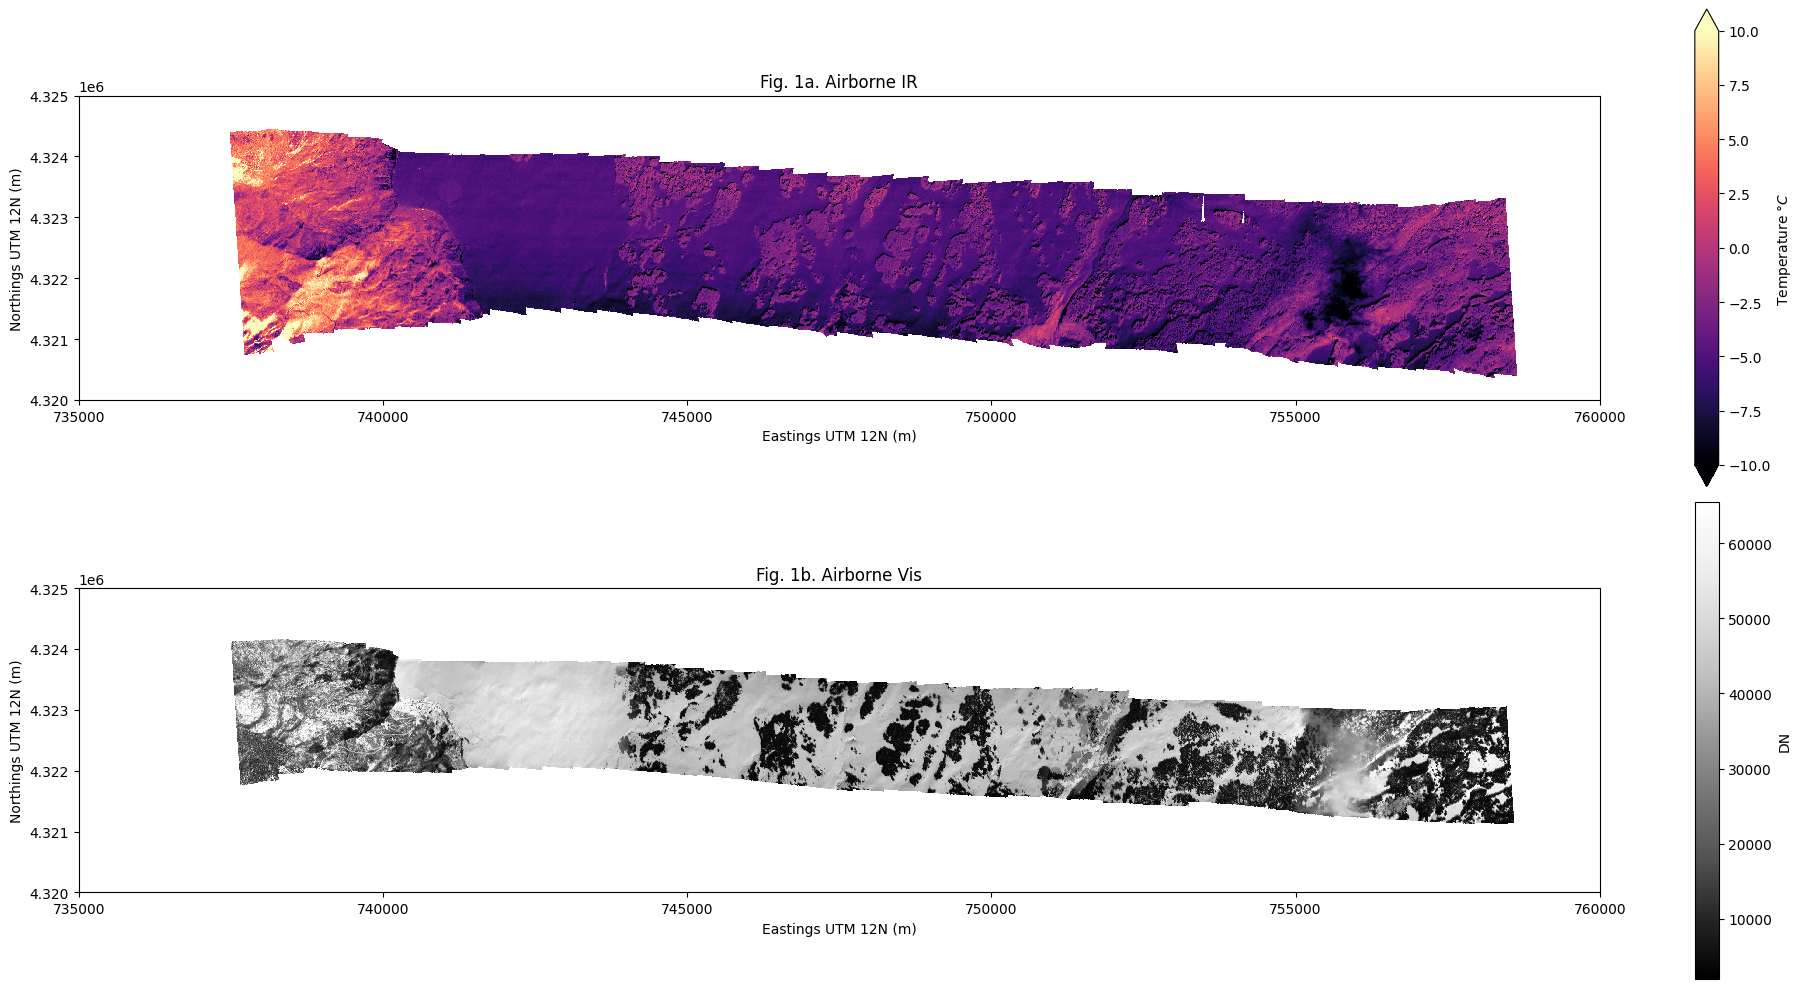

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), tight_layout=True)

# Plot the IR imagery
airborne_ir.plot(
    ax=axs[0],
    cmap="magma",
    vmin=-10,
    vmax=10,
    cbar_kwargs={"label": r"Temperature $\degree C$"},
)
axs[0].set_title("Fig. 1a. Airborne IR")

# Plot the visible imagery
airborne_vis.plot(ax=axs[1], cmap="Greys_r", cbar_kwargs={"label": "DN"})
axs[1].set_title("Fig. 1b. Airborne Vis")

# for each subplot, do the following:
for ax in axs:
    ax.set_aspect("equal")  # set the aspect ratio to "equal"

    # give each axis a label
    ax.set_xlabel("Eastings UTM 12N (m)")
    ax.set_ylabel("Northings UTM 12N (m)")

    # set the axes limits, units in meters UTM Zone 12N (I chose these values by just looking at the plot above)
    ax.set_xlim((735000, 760000))  # x axis limits
    ax.set_ylim((4320000, 4325000))  # y axis limits

   
> **Lab Question (1):** :question:  
> <ol type="a"> 
> <li> Describe the spatial patterns of snow surface temperature visible in this airborne image. Use the visible images to aid your interpretations. </li>

------

## Part 2: Ground-based temperatures from a snowpit :snowflake:  

To provide validate and evaluate the accuracy airborne data, we will also examine snow surface temperature measurements collected using a ground-based radiometer. 

On February 5, 2020, the SnowEx team installed a thermal infrared radiometer pointing at the snow surface at snow pit #2S10 (left), and buried temperature sensors beneath the snow surface (right). These logged observations at 5-minute intervals until they are removed a week later on February 12.

<p align = "center"> 
<img src="./images/snowpit_2s10.png" alt="snowpit" width="1000"/> </p>
<em>Snow temperature sensor setup at snow pit 2S10: (left) tripod-mounted thermal ifrared radiometer to measure snow surface, (right) temperature probes to be buried beneath the snow surface.
(Photos by Steven Pestana)</em>

:white_check_mark: **We will import the radiometer snow temperature timeseries dataset from Site 2S10:** 

- This data is available through NSIDC, but we have already downloaded a local copy for this tutorial located in the <code>snow-temperature-timeseries</code> subfolder inside <code>thermal-ir</code>. You can read more about this raw data file from the dataset’s README.txt in this subfolder. 

In [7]:
# First, we will create a list of column headers according to the readme file:

column_headers = [
    "table",
    "year",
    "doy",
    "time",  # year, day of year, time of day (local time, UTC-7)
    "rad_avg",
    "rad_max",
    "rad_min",
    "rad_std",  # radiometer surface temperature
    "sb_avg",
    "sb_max",
    "sb_min",
    "sb_std",  # radiometer sensor body temperature (for calibration)
    "temp1_avg",
    "temp1_max",
    "temp1_min",
    "temp1_std",  # temperature at 5 cm below snow surface
    "temp2_avg",
    "temp2_max",
    "temp2_min",
    "temp2_std",  #               10 cm
    "temp3_avg",
    "temp3_max",
    "temp3_min",
    "temp3_std",  #               15 cm
    "temp4_avg",
    "temp4_max",
    "temp4_min",
    "temp4_std",  #               20 cm
    "temp5_avg",
    "temp5_max",
    "temp5_min",
    "temp5_std",  #               30 cm
    "batt_a",
    "batt_b",  # battery voltage data
]

# Load the ground-based snow temperature data:
df = pd.read_csv(
    "thermal-ir/SNEX20_VPTS_Raw/Level-0/snow-temperature-timeseries/CR10X_GM1_final_storage_1.dat",
    header=None,
    names=column_headers,
)
df["time_str"] = [
    ("0" * (4 - len(str(df.time[i])))) + str(df.time[i]) for i in range(df.shape[0])
]
df.loc[df["time_str"] == "2400", "doy"] += 1
df.replace({"time_str": {"2400": "0000"}}, inplace=True)

# Create a datetime value:
df.index = compose_date(
    df["year"],
    days=df["doy"],
    hours=df["time_str"].str[:2],
    minutes=df["time_str"].str[2:],
)
df = df[df.table != 102]
df.drop(
    columns=["table", "year", "doy", "time", "time_str", "batt_a", "batt_b"],
    inplace=True,
)

# Inspect the ground-based snow temperature database:
df.head()

,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,sb_min,sb_std,temp1_avg,temp1_max,...,temp3_min,temp3_std,temp4_avg,temp4_max,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std
2020-01-30 15:37:00,22.963,22.963,22.963,0.000,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:38:00,22.962,22.963,22.961,0.001,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:39:00,25.080,26.810,22.968,1.484,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:40:00,25.320,25.569,25.133,0.184,22.839,22.846,22.832,0.005,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:41:00,24.894,25.069,24.611,0.182,22.860,22.860,22.860,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0


**Next, we will plot the ground-based snow temperature using the variable <code>rad_avg</code>, which is the average temperature measured by the radiometer over each 5 minute period:**

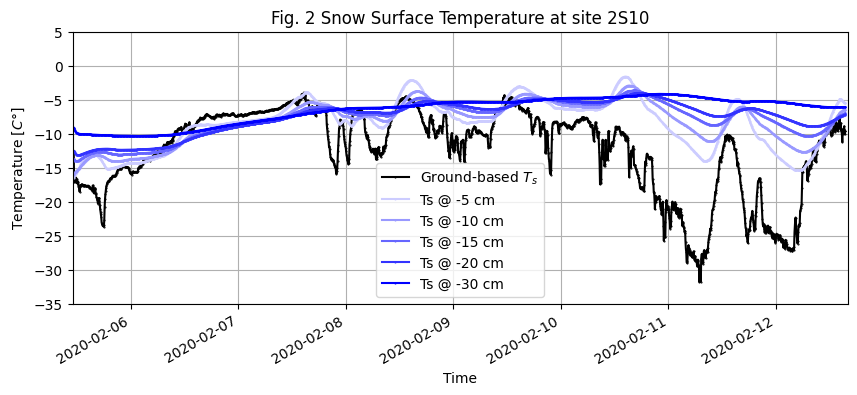

In [ ]:
plt.figure(figsize=(10, 4))
df.rad_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0, 0, 0], label="Ground-based $T_s$"
)
df.temp1_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0.8, 0.8, 1], label="Ts @ -5 cm"
)
df.temp2_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0.6, 0.6, 1], label="Ts @ -10 cm"
)
df.temp3_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0.4, 0.4, 1], label="Ts @ -15 cm"
)
df.temp4_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0.2, 0.2, 1], label="Ts @ -20 cm"
)
df.temp5_avg.plot(
    linestyle="-", marker=".", markersize=1, c=[0, 0, 1], label="Ts @ -30 cm"
)
# set plot limits
plt.ylim((-35, 5))
plt.xlim((pd.Timestamp(2020, 2, 5, 11, 0), pd.Timestamp(2020, 2, 12, 16, 0)))
plt.legend()
plt.ylabel(r"Temperature [$C\degree$]")
plt.xlabel("Time")
plt.grid("on")
plt.title("Fig. 2a. Snow Surface Temperature at site 2S10")
ground_df = df  # save the ground data for later use

- But then we want to focus on the date/time when our IR image was from, so zoom in on Feb 8th by changing our plot’s xlim: 

In [ ]:
plt.figure(figsize=(10, 4))

# plot radiometer average temperature
df.rad_avg.plot(
    linestyle="-", marker="", markersize=1, c="k", label="Ground-based $T_s$"
)

# set axes limits
plt.ylim((-15, 0))  # set some temperature y-axis limits for our plot
plt.xlim(
    (pd.Timestamp(2020, 2, 8, 6, 0), pd.Timestamp(2020, 2, 8, 20, 0))
)  # zoom in to daytime hours on Feb. 8, 2020

# add a legend to the plot
plt.legend()

# set axes labels
plt.ylabel("Temperature [$C\degree$]")
plt.xlabel("Time")

# add grid lines to the plot
plt.grid("on")

# set the plot title
plt.title("Fig. 2b. Snow Surface Temperature at Snow Pit 2S10");

> **Lab Question (2):** :question:
> 
> - a) Using Fig. 2b, describe the variations in snow surface temperature (black) over a 24-hour period on Feb 8th. 
>
> - b) Calulcate the mean, minimium, and maximum temperature. 
> 
> - c) Identify the time of day when the snow surface temperature is highest and lowest.

-----------

## Part 3: Comparing ground-based and airborne temperature data

**To compare the temperature observations, first we will find out more about the snow pit site information.**
- We can find this information through a query to the SnowEx SQL database using <code>get_site_date</code>


In [9]:
site_id, data_id = "2S10", "130"
siteData_df = get_site_data(site_id, data_id)
display(HTML(siteData_df.head().to_html()))

,pit_id,slope_angle,aspect,air_temp,total_depth,weather_description,precip,sky_cover,wind,ground_condition,ground_roughness,ground_vegetation,vegetation_height,tree_canopy,site_notes,latitude,longitude,northing,easting,elevation,utm_zone,geom,time,site_id,site_name,date,time_created,time_updated,id,doi,date_accessed
0,COGM2S10_20200205,0.0,None,18.5,77.0,"Sunny and cold, some blowing snow",None,Few (< 1/4 of sky),Moderate,Frozen,Rough,"Grass, Shrub","20, 30",No Trees,None,39.019474,-108.192316,4322689.0,743076.0,None,12,POINT (743076 4322689),16:45:00+00:00,2S10,Grand Mesa,2020-02-05,2022-06-30 22:28:52.494279+00:00,None,130,https://doi.org/10.5067/DUD2VZEVBJ7S,None


- Using the latitude and longitude information from the database above, we can overlay the ground-based radiometer/snow-pit site on the airborne IR image: 

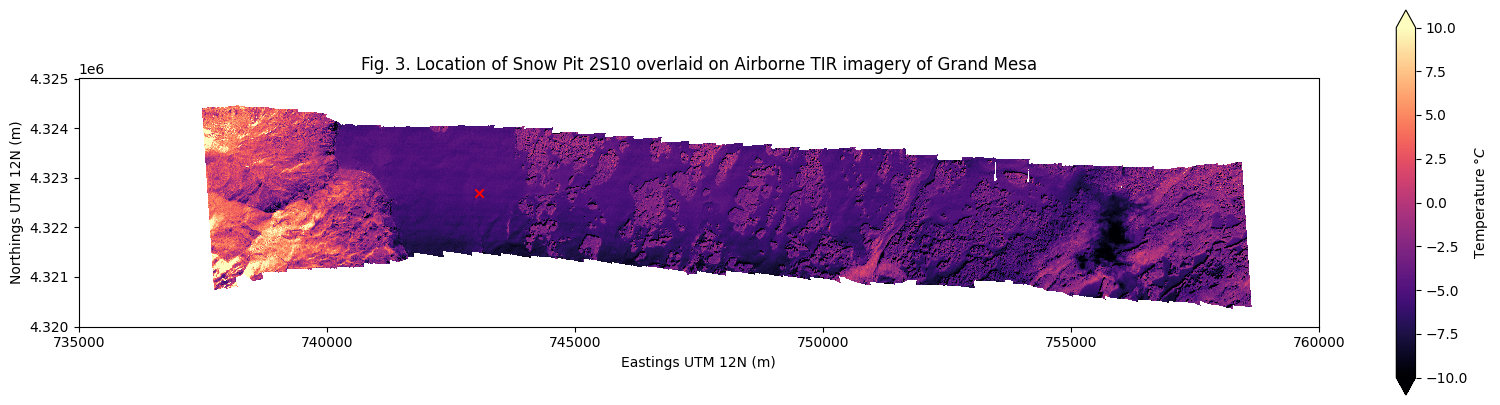

In [10]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_aspect("equal")

# plot the airborne infrared image
airborne_ir.plot(
    cmap="magma",
    vmin=-10,
    vmax=10,
    ax=ax,
    cbar_kwargs={"label": r"Temperature $\degree C$"},
)

# plot the location of the snow pit
siteData_df.plot(ax=ax, color="r", marker="x")
ax.set_xlabel("Eastings UTM 12N (m)")
ax.set_ylabel("Northings UTM 12N (m)")
ax.set_xlim((735000, 760000))
ax.set_ylim((4320000, 4325000))
ax.set_title(
    "Fig. 3. Location of Snow Pit 2S10 overlaid on Airborne TIR imagery of Grand Mesa"
);

> :memo: **Important Note:**
> - Because of the differnces in spatial resolution, we will examine the comparison by averaging the airborne IR temperatures within a 100 m radius surrounding the snow pit site (instead of using data from a single image pixel). 

In [11]:
# Extract the airborne IR data at the snow pit location:
airborne_ir_point_temperature = airborne_ir.rio.clip(siteData_df.geometry)

# Build a 100 m radius buffer around the snow pit to obtain an averaged airborne IR temperatures:
r = 100
siteData_df_buffer = siteData_df.buffer(r)

- Calculate the averaged temperature in this 100 m radius polygon: 

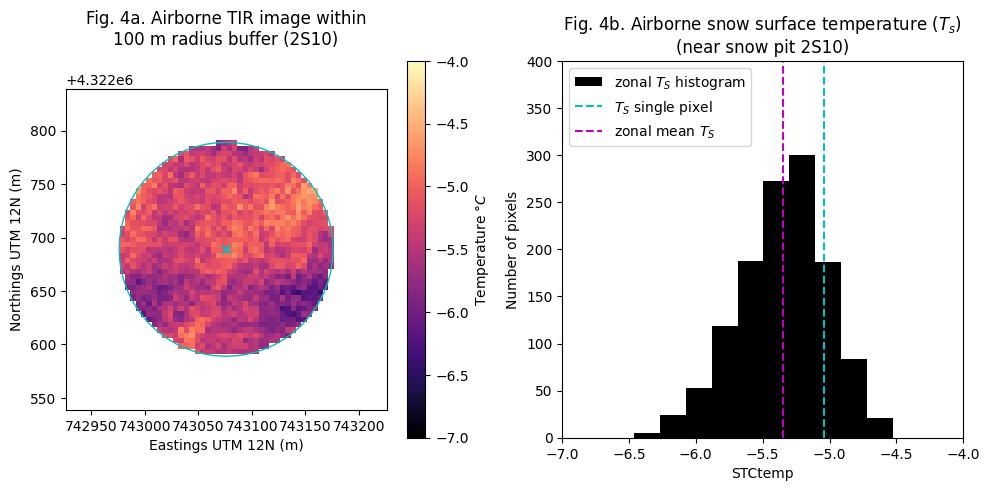

In [12]:
# Clip again using our new geometry
airborne_ir_area_temperature = airborne_ir.rio.clip(siteData_df_buffer.geometry)

# Plotting the results for comparison:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)

# Plot the airborne IR clipped data:
airborne_ir_area_temperature.plot(
    cmap="magma",
    vmin=-7,
    vmax=-4,
    ax=ax[0],
    cbar_kwargs={"label": r"Temperature $\degree C$"},
)
ax[0].set_title("Fig. 4a. Airborne TIR image within\n100 m radius buffer (2S10)\n")
ax[0].set_aspect("equal")
ax[0].set_xlabel("Eastings UTM 12N (m)")
ax[0].set_ylabel("Northings UTM 12N (m)")
xmin, ymin, xmax, ymax = siteData_df.geometry.total_bounds
ax[0].set_xlim((xmin - 150, xmax + 150))
ax[0].set_ylim((ymin - 150, ymax + 150))

# Plot the ground-based radiometer location:
siteData_df.plot(ax=ax[0], color="c", marker="x")
siteData_df_buffer.plot(ax=ax[0], edgecolor="c", facecolor="none")

# Display the airborne IR temperarure as a histogram:
airborne_ir_area_temperature.plot.hist(
    ax=ax[1],
    color="k",
    zorder=1,
    label="zonal $T_S$ histogram",
)

# plot a vertical line for the single-pixel temperature we think is right at the snow pit
ax[1].axvline(
    airborne_ir_point_temperature,
    color="c",
    linestyle="--",  # set color and style
    zorder=2,  # use zorder to make sure this plots on top of the histogram
    label="$T_S$ single pixel",
)

# plot a vertical line for the mean temperature within the buffer area geometry
ax[1].axvline(
    airborne_ir_area_temperature.mean(),
    color="m",
    linestyle="--",  # set color and style
    zorder=2,  # use zorder to make sure this plots on top of the histogram
    label="zonal mean $T_S$",
)
ax[1].legend(loc="upper left")  # add a legend
ax[1].set_xlim((-7, -4))  # set xlim to same values as colorbar in image plot
ax[1].set_ylim((0, 400))  # set ylim
ax[1].set_title(
    "Fig. 4b. Airborne snow surface temperature ($T_{s}$)\n(near snow pit 2S10)"
)
ax[1].set_ylabel("Number of pixels");


> **Lab Question (3):** :question: 
> - Looking at the zonal mean airborne $T_{s}$ (pink line) vs. the value from a single pixel (cyan line), how do these airborne temperature compare? 
> - Going back to the ground-based temperature shown in _Fig. 2_, how do the airborne $T_{s}$ values compare with the ground observations? 
> - Discuss potential reasons for the differences between airborne and ground-based measurements.


----

## Part 3: Satellite Thermal Infrared (TIR) Obsevations :satellite: 

> **Advantages of satellite IR imagery:**
> - We don’t always have airplanes with IR cameras flying around. Satellites can provide images at more regular intervals for long-term studies, and can see areas that are difficult to access on the ground or by air.
>
> - As such, we will also examine the ASTER Level 1 Precision Terrain Corrected Registered At-Sensor Radiance (AST_L1T) product. [Product documentation is available here](https://lpdaac.usgs.gov/products/ast_l1tv003/). 
> - We will compare an ASTER IR image of Grand Mesa that was taken at roughly the same time as the airborne IR image. We will examine data from Band 14 which is sensitive to radiance in the 10.95-11.65 µm wavelength.


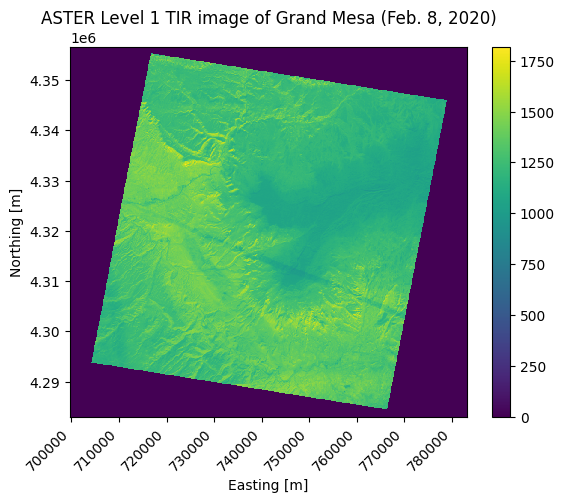

In [13]:
# Load and inspect the ASTER image:
aster_ir = rioxarray.open_rasterio(
    "thermal-ir/AST_L1T_00302082020180748_20200209065849_17218_ImageData14.tif"
)
aster_ir = reproject_geospatial(aster_ir)
aster_ir_timestamp = pd.Timestamp(2020, 2, 8, 18, 7, 48) - pd.Timedelta(hours=7)

# Plot the ASTER image:
fig, ax = plt.subplots()
aster_ir.plot(ax=ax)
ax.set_xlabel("Easting [m]")
ax.set_ylabel("Northing [m]")
ax.set_title("ASTER Level 1 TIR image of Grand Mesa (Feb. 8, 2020)")
plt.xticks(rotation=45, ha="right")
plt.show()

**Converting ASTER data to brightness temperature:**
  
From the ASTER Product Documentation, we can see that the values on the plot above are stored as scaled “digital number” (DN) values rather than the actual radiance values. We will convert DN to radiance, and radiance to brightness temperatures using two custom functions: 


In [14]:
# Apply the conversion functions to the ASTER image:
aster_band14_rad = tir_dn2rad(aster_ir, band=14)  # convert from DN to radiance
aster_band14_tb_k = tir_rad2tb(aster_band14_rad, band=14)

# Convert from radiance to brightness temperature (K)
aster_band14_tb_c = aster_band14_tb_k - 273.15  # convert from K to C
aster_band14_tb_c.rio.write_crs(aster_ir.rio.crs, inplace=True);

# Note that an "RuntimeWarning: invalid value encountered..." warning may pop up here. This is because the above function tries to take the log of "nan" values that are outside the imaged area
# we can ignore this warning and proceed

/Users/winniechu/Documents/Teaching/Glaciology/2025/remote_sensing/remote-sensing-lab/.venv/lib/python3.12/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


- Plot our image again, this time setting our colorscale and colorbar values. We should see “realistic” surface temperature values in degrees C now.

/Users/winniechu/Documents/Teaching/Glaciology/2025/remote_sensing/remote-sensing-lab/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


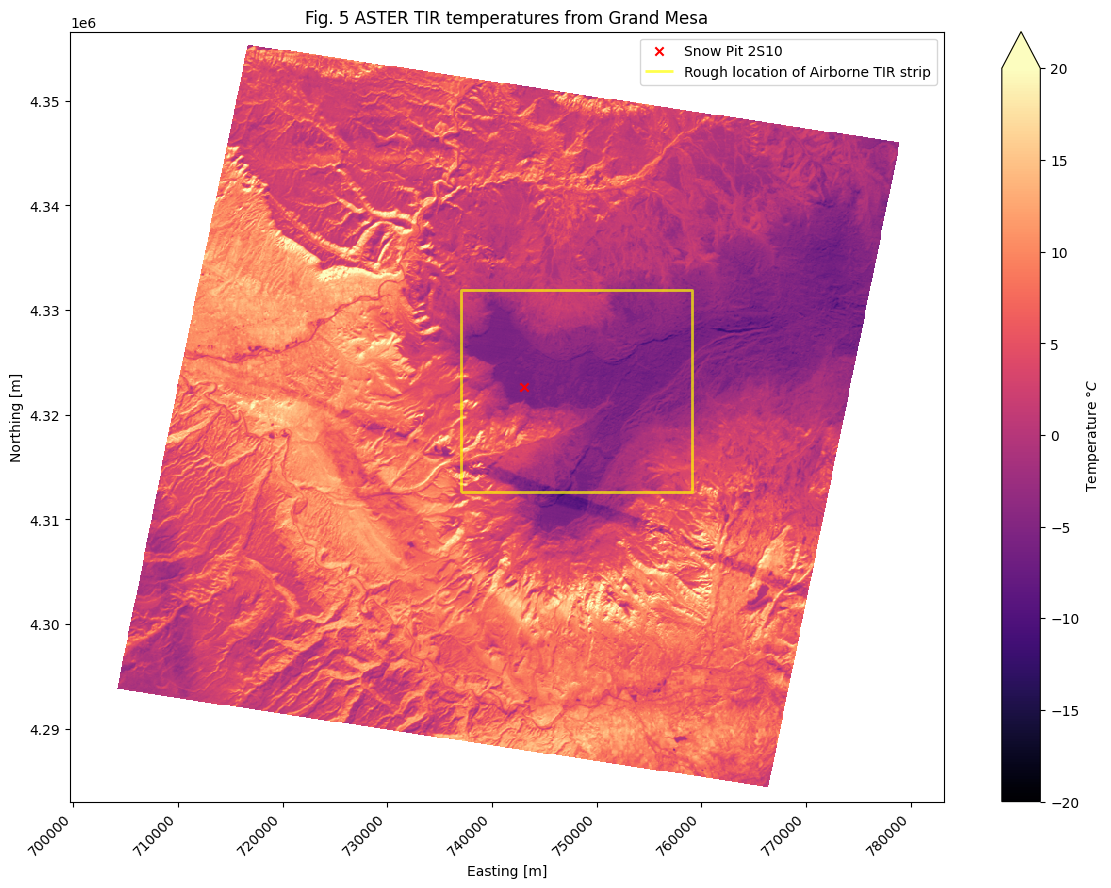

In [15]:
# Plot the Converted ASTER image showing surface temperatures:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_aspect("equal")
aster_band14_tb_c.plot(
    ax=ax,
    cmap="magma",
    vmin=-20,
    vmax=20,
    cbar_kwargs={"label": r"Temperature $\degree C$"},
)
# Plot the location of the snow pit:
siteData_df.plot(ax=ax, color="r", marker="x", label="Snow Pit 2S10")

# Plot the approximate location of the Airborne TIR imagery:
airborne_bounds = airborne_ir.rio.bounds()
airborne_coords = [
    (airborne_bounds[0], airborne_bounds[1]),  # bottom-left
    (airborne_bounds[2], airborne_bounds[1]),  # bottom-right
    (airborne_bounds[2], airborne_bounds[3]),  # top-right
    (airborne_bounds[0], airborne_bounds[3]),  # top-left
]
airborne_polygon = Polygon(airborne_coords)
airborne_gdf = gpd.GeoDataFrame(
    {"geometry": [airborne_polygon]}, crs=airborne_ir.rio.crs
)
airborne_gdf.boundary.plot(
    ax=ax,
    edgecolor="yellow",
    linewidth=2,
    label="Rough location of Airborne TIR strip",
    alpha=0.7,
)

ax.set_xlabel("Easting [m]")
ax.set_ylabel("Northing [m]")
ax.set_title("Fig. 5 ASTER TIR temperatures from Grand Mesa")
plt.xticks(rotation=45, ha="right")
ax.legend()
plt.show();

> **Lab Question (4):** :question: 
> <ol type="a"> 
> <li> Describe the ASTER temperature distribution around the ground-based (red cross) and airborne observations (yellow box) areas. </li>

**Similar to the airborne IR analysis, we will compare ASTER and ground-based observations by calculating a zonal averaged surface temperature from a 100 m radius buffer zone around the snow pit site.**

In [16]:
# First clip to the single point
aster_band14_tb_c_point_temperature = aster_band14_tb_c.rio.clip(siteData_df.geometry)

# Second clip to the 100 m radius buffered area
buffer_distance = 100  # in meters
buffer_geometry = siteData_df.geometry.buffer(buffer_distance)

# Mask the ASTER temperature data with the buffer area
masked_aster = aster_band14_tb_c.rio.clip(buffer_geometry, all_touched=True, drop=True)

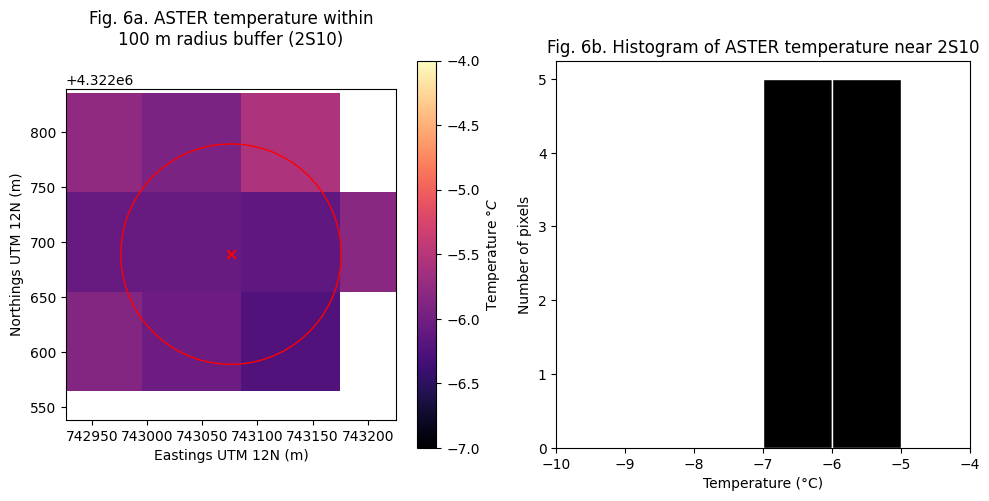

In [17]:
# plot the portion of the airborne TIR image we selected within the buffer area geometr
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)

masked_aster.plot(
    cmap="magma",
    vmin=-7,
    vmax=-4,
    ax=ax[0],
    cbar_kwargs={"label": r"Temperature $\degree C$"},
)
ax[0].set_title("Fig. 6a. ASTER temperature within\n100 m radius buffer (2S10)\n")
ax[0].set_aspect("equal")
ax[0].set_xlabel("Eastings UTM 12N (m)")
ax[0].set_ylabel("Northings UTM 12N (m)")
ax[0].set_xlim(
    (xmin - 150, xmax + 150)
)  # x axis limits to +/- 150 m from our point's "total bounds"
ax[0].set_ylim(
    (ymin - 150, ymax + 150)
)  # y axis limits to +/- 150 m from our point's "total bounds"

# plot the location of the snow pit of interest to the plot
siteData_df.plot(ax=ax[0], color="r", marker="x")

# plot the area of the buffer we made around the snow pit
siteData_df_buffer.plot(ax=ax[0], edgecolor="r", facecolor="none")

# Plot a histogram of ASTER temperature data within the buffer area
masked_aster.plot.hist(
    ax=ax[1],
    bins=np.arange(-20, 21, 1),  # Set the bin range and size
    color="k",
    edgecolor="white",  # Add white edges to the bins for better visibility
)

ax[1].set_xlim((-20, 20))
ax[1].set_title("Fig. 6b. Histogram of ASTER temperature near 2S10")
ax[1].set_xlabel("Temperature (°C)")
ax[1].set_ylabel("Number of pixels")
ax[1].set_xlim((-10, -4))
plt.tight_layout()
plt.show()

## Part 4: Multi-platform comparison :snowman:

**In the final task, we will compare the two remote sensing dataset (airborne and ASTER) by plotting their temperature values on to the ground-based snowpit radiometer timeseries:**
   - We will add “error bars” onto this plot to represent the distribution of ASTER and airborne temperatures within the 100 m radius area around the snow pit.

/var/folders/m4/06n6v3nx7cb_1hv0jwk0x4k80000gn/T/ipykernel_58415/3773626521.py:9: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(


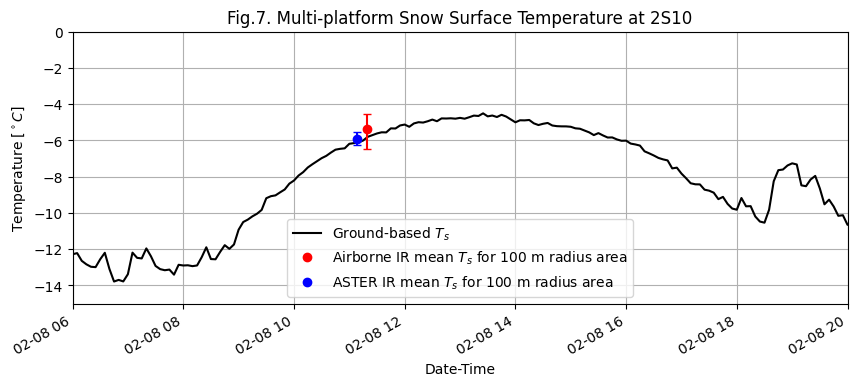

In [18]:
plt.figure(figsize=(10, 4))

# plot radiometer average temperature
ground_df.rad_avg.plot(
    linestyle="-", marker="", markersize=1, c="k", label=r"Ground-based $T_s$"
)

# plot the mean airborne IR temperature from the area around the snow pit:
plt.plot(
    airborne_ir_timestamp,
    airborne_ir_area_temperature.mean(),
    marker="o",
    c="r",
    linestyle="none",
    label=r"Airborne IR mean $T_s$ for 100 m radius area",
)
# plot an error bar showing the maximum and minimum airborne IR temperature around the snow pit
plt.errorbar(
    airborne_ir_timestamp,
    airborne_ir_area_temperature.mean(),
    yerr=[
        [airborne_ir_area_temperature.mean() - airborne_ir_area_temperature.min()],
        [airborne_ir_area_temperature.max() - airborne_ir_area_temperature.mean()],
    ],
    capsize=3,
    fmt="none",
    ecolor="r",
)

# plot the mean ASTER IR temperature from the area around the snow pit:
plt.plot(
    aster_ir_timestamp,
    masked_aster.mean(),
    marker="o",
    c="b",
    linestyle="none",
    label=r"ASTER IR mean $T_s$ for 100 m radius area",
)
# plot an error bar showing the maximum and minimum ASTER IR temperature around the snow pit
plt.errorbar(
    aster_ir_timestamp,
    masked_aster.mean(),
    yerr=[
        [masked_aster.mean() - masked_aster.min()],
        [masked_aster.max() - masked_aster.mean()],
    ],
    capsize=3,
    fmt="none",
    ecolor="b",
)

# set axes limits
plt.ylim((-15, 0))
plt.xlim((pd.Timestamp(2020, 2, 8, 6, 0), pd.Timestamp(2020, 2, 8, 20, 0)))
plt.legend()
plt.ylabel(r"Temperature [$^\circ C$]")
plt.xlabel("Date-Time")
plt.grid("on")
plt.title("Fig.7. Multi-platform Snow Surface Temperature at 2S10");

> **Lab Question (5):** :question: 
>
> - a) Describe the temperature differences between the three datasets (airborne, ASTER, ground-based radiometer) around the date-time (02-08 11) where they roughly overlapped. To aid your answer, examine the mean, standard deviation, and the range (represented by the error bar) of these three datasets more closely. 
> 
> - b) Suggest some reasons behind these temperature discrepencies. _HINT:_ Review the instrument specification shown in [Table 1](#spec).  
> 
> - c) Using _Table 1_, propagate sensor accuracy specificiation by rearranging the radiative transfer equation shown in _Equation 1_ as follows: 
> $T = \frac{L}{\varepsilon\sigma}^{1/4}$. Compare resulting temperature uncertainities across the three platforms. 
>
> - d) Based on your interpretation about the three type of IR platforms, in a paragraph, suggest a hypothetical cryospheric or planetary science research question that leverages the strengths of one or several of TIR observation methods. Explain which TIR sensor(s) and dateset(s) you would use and why. 
